# A few MNIST experiements with TensorFlow

First, setup TensorFlow, numpy and other libraries:

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plot
from IPython import display

%matplotlib inline

import time
import os

Get the data:

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets("./data/", one_hot=False)


Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
def plotImages(images, imagesToShow = 10):
    #plot.rcParams["figure.figsize"] = 10, 10
    imgs = images[np.random.randint(images.shape[0], size=imagesToShow)]
    plot.imshow(np.hstack([(1.0 - i).reshape((28, 28)) for i in imgs]), cmap="gray")
    #display.display(plot.gcf())

Examples of images from the training set:

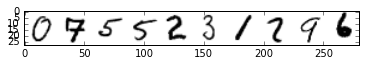

In [4]:
plotImages(mnist.train.images)

Define various layer types (inputs, fully-connected, convolutional, loss etc):

In [5]:
image_size = 28
label_size = 10
# Input image dimensions (single channel)
input_dims = [image_size, image_size, 1]

# Features and labels
def inputs():
    features = tf.placeholder(tf.float32, shape=[None] + input_dims, name="features")
    labels = tf.placeholder(tf.float32, shape=[None], name="labels")
    return features, labels

# Cross-entropy loss with softmax activation function
def ce_sm_loss(logits, labels):
    with tf.name_scope("loss"):
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf.cast(labels, tf.int32), name="ce")
        return tf.reduce_mean(ce, name="ce_mean")

# Outputs (probabilities)
def probs_layer(logits):
    return tf.nn.softmax(logits)

# Fully-connected layer
# Helper function
def _fc_layer(x, size):
    # Flatten dims for the fully-connected layer.
    x_flat = tf.reshape(x, [-1, x.get_shape()[1:].num_elements()])
    shape = [x_flat.get_shape()[1].value, size]
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1), name="weights")
    b = tf.Variable(tf.constant(0.01, shape=[shape[1]]), name="biases")
    return tf.matmul(x_flat, W) + b

# FC layer, no activation
def fc_layer(x, size, name):
    with tf.name_scope(name):
        return _fc_layer(x, size)
    
# FC layer with ReLU
def fc_relu_layer(x, size, name=''):
    with tf.name_scope(name) as scope:
        return tf.nn.relu(_fc_layer(x, size), name=scope)

# 2D convolutional layer with ReLU
def conv2d_relu_layer(x, kSize, mapCount=1, stride=1, name=''):
    with tf.name_scope(name) as scope:
        # assuming x is already a 4D tensor
        shape = [kSize, kSize, x.get_shape()[3].value, mapCount]
        W = tf.Variable(tf.truncated_normal(shape, stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.01, shape=[mapCount]), name="biases")
        conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME', name="conv")
        return tf.nn.relu(conv + b, name=scope)

# Spatial max pooling layer
def max_pool(x, kSize, stride=0, name=''):
    if stride <= 0:
        stride = kSize
    with tf.name_scope(name):
        return tf.nn.max_pool(x, ksize=[1, kSize, kSize, 1], strides=[1, stride, stride, 1], 
                              padding='SAME', name="pool")


## Network topologies

### Simple, one-hidden layer net:

In [6]:
def simple_net(features):
    h1_size = 200
    h1 = fc_relu_layer(features, h1_size, "h1")
    return h1

### Convolutional net:
5 layers: `convolution -> max pool -> convolution -> max pool -> fully-connected`

In [7]:
def conv_net_01(features):
    conv1 = conv2d_relu_layer(features, 5, 32, name='conv1')
    pool1 = max_pool(conv1, 2, name='pool1')
    conv2 = conv2d_relu_layer(pool1, 5, 32, name='conv2')
    pool2 = max_pool(conv2, 2, name='pool2')
    fc1 = fc_relu_layer(pool2, 128, 'fc1')
    return fc1

Graph visualization from TensorBoard:
![conv_net_01](images/conv_01_graph.png)

### Operations and actions
Define operations such as training and actions like train, evaluate and so on.

In [8]:
# Training step operation
def create_train_op(loss, learning_rate, momentum):
    tf.scalar_summary(loss.op.name, loss)
    step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    return step

def get_next_feed(dataset, batch_size, features, labels):
    f, l = dataset.next_batch(batch_size)
    return {features: f.reshape([batch_size] + input_dims), labels: l}
    
# Training action - performs training using provided train step and inputs
def do_train(sess, train_step, loss, next_feed, batch_size, epoch_size, num_epochs, 
             summary_op, summary_writer):
    for epoch in range(0, num_epochs):
        epoch_loss = 0.0
        for i in range(0, epoch_size, batch_size):
            cur_batch_size = min(batch_size, epoch_size - i)
            feed_dict = next_feed(cur_batch_size)
            _, loss_val = sess.run([train_step, loss], feed_dict=feed_dict)
            epoch_loss += np.sum(loss_val)
            if i % 1000 == 0:
                summary_str = sess.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, epoch * epoch_size + i)
                summary_writer.flush()
                
        print "Epoch %d: loss = %0.05f" % (epoch, epoch_loss / epoch_size)
        
# Evaluation of a model on a given dataset    
def do_eval(sess, logits, labels, next_feed, batch_size, epoch_size):
    batch_correct = tf.reduce_sum(tf.cast(tf.nn.in_top_k(logits, tf.cast(labels, tf.int32), 1), tf.int32))
    correct = 0
    total = 0
    for i in range(0, epoch_size, batch_size):
        cur_batch_size = min(batch_size, epoch_size - i)
        feed_dict = next_feed(cur_batch_size)
        correct += np.sum(sess.run(batch_correct, feed_dict=feed_dict))
        total += cur_batch_size

    return total, correct


Build and execute the graph:

In [17]:
def train_and_evaluate(net):
    with tf.Graph().as_default():
        # Build the network for training
        features, labels = inputs()
        
        logits = fc_layer(net(features), label_size, "logits")
        probs = probs_layer(logits)
        loss = ce_sm_loss(logits, labels)

        # Create train operation
        train_step = create_train_op(loss, learning_rate=0.1, momentum=0)

        g = tf.get_default_graph()
        ww = g.get_tensor_by_name("conv1/weights:0")
        #ww1 = tf.transpose(tf.split(3, 32, ww)[0], [3, 0, 1, 2])
        ww1 = tf.reshape(ww, (1, 5, 5 * 32, 1))
        tf.image_summary("ww", ww1, max_images=1)
        
        # Summary operation
        summary_op = tf.merge_all_summaries()

        with tf.Session() as sess:
            # TensorBoard needs a separate folder for each run.
            log_dir = "/data/tf/log/" + time.strftime("%Y%m%d%H%M%S")
            summary_writer = tf.train.SummaryWriter(log_dir, sess.graph)

            sess.run(tf.initialize_all_variables())

            # Train model
            batch_size = 64
            epoch_size = mnist.train.num_examples
            num_epochs = 1
            next_feed = lambda b: get_next_feed(mnist.train, b, features, labels)
            do_train(sess, train_step, loss, next_feed, batch_size, epoch_size, num_epochs,
                    summary_op, summary_writer)

            # Evaluate model on test dataset
            next_feed = lambda b: get_next_feed(mnist.test, b, features, labels)
            total, correct_count = do_eval(sess, probs, labels, next_feed, 100, mnist.test.num_examples)
            print('Test set accuracy: %0.04f (%d/%d)' % (correct_count / float(total), correct_count, total))

train_and_evaluate(conv_net_01)

Epoch 0: loss = 0.00312
Test set accuracy: 0.9809 (9809/10000)


#### Training fully-connected net

In [10]:
#train_and_evaluate(simple_net)

Loss graph for fully-connected net (from TensorBoard):
![fc_loss](images/fc_loss.png)

#### Training convolutional net

In [11]:
#train_and_evaluate(conv_net_01)

Loss graph for convolutional net (from TensorBoard):
![fc_loss](images/conv_01_loss.png)